In [1]:
!pip install plotly
!pip install kneed
%pip install prophet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import json

In [3]:
def determine_anomaly_weight(df, row):
  if row['is_anomaly'] == 1:
    #print(f"Processing anomaly at {df['ds']}")
    subset = df[(df['ds'] >= row['ds'] - pd.Timedelta(hours=8)) & (df['ds'] <= row['ds'] + pd.Timedelta(hours=8))]
    #print(len(subset))
    if not subset.empty:
      #print("Subset is not empty")
      result = min(abs(subset['yhat_upper'] - row['y']).min(),
                      abs(subset['yhat_lower'] - row['y']).min())
    else:
        #print("Subset is empty")
        result = abs(row['yhat_upper'] - row['y'])
  else:
    result = 0
  return result

In [4]:
def prophet_model(df, dimension):

  subset = df[['time', dimension]].reset_index()
  subset = subset.assign(y=subset[dimension]).assign(ds=subset['time']).drop(columns=['time', dimension])

  #Initializing and fitting the prophet model
  m = Prophet()
  m.fit(subset)

  #Creating prophet predictions on historical data
  future = m.make_future_dataframe(periods=0)
  forecast = m.predict(future)

  #Assigning forecast dataframe the initial y values (no. of events using this device), is_anomaly (if it is an anomaly or not), and anomaly_weight (how far it is from either yhat_upper or lower)
  forecast['y'] = subset['y']
  forecast['is_anomaly'] = forecast.apply(lambda row: 1 if not (row['yhat_lower'] <= row['y'] <= row['yhat_upper']) else 0, axis=1)
  forecast['diff'] = abs(forecast['yhat'] - forecast['y'])
  forecast['percent_diff'] = (abs(forecast['yhat'] - forecast['y'])/forecast['y'].where(forecast['y'] != 0))
  forecast['anomaly_weight'] = forecast.apply(lambda row: determine_anomaly_weight(forecast, row), axis=1)

  #Plotting forecast, anomaly, and forecast components
  plt.figure(figsize=(30, 20))  # Set the figure size to a larger size (width=12, height=8)
  fig1 = m.plot(forecast)
  anomalies = forecast[forecast['is_anomaly'] == 1]
  plt.scatter(anomalies['ds'], anomalies['y'], color='red', s=20, label='Anomalies')
  plt.title(f"{dimension}")

  return forecast[['ds', 'yhat_lower', 'yhat_upper', 'yhat', 'y', 'is_anomaly', "diff","percent_diff"]]

In [5]:
visitors_by_geography = pd.read_csv('visitors_by_geography.csv')
visitors_by_device = pd.read_csv('visitors_by_device.csv')
buyers_by_geography = pd.read_csv('buyers_by_geography.csv')
buyers_by_device = pd.read_csv('buyers_by_device.csv')
orders_by_geography = pd.read_csv('orders_by_geography.csv')
orders_by_device = pd.read_csv('orders_by_device.csv')

visitors_by_geography['time'] = pd.to_datetime(visitors_by_geography['time'], format='mixed')
visitors_by_geography['time'] = visitors_by_geography['time'].dt.tz_localize(None)
visitors_by_geography["time"] = visitors_by_geography["time"].dt.floor("h")

visitors_by_device['time'] = pd.to_datetime(visitors_by_device['time'], format='mixed')
visitors_by_device['time'] = visitors_by_device['time'].dt.tz_localize(None)
visitors_by_device["time"] = visitors_by_device["time"].dt.floor("h")

orders_by_geography['time'] = pd.to_datetime(orders_by_geography['time'], format='mixed')
orders_by_geography['time'] = orders_by_geography['time'].dt.tz_localize(None)
orders_by_geography["time"] = orders_by_geography["time"].dt.floor("h")

orders_by_device['time'] = pd.to_datetime(orders_by_device['time'], format='mixed')
orders_by_device['time'] = orders_by_device['time'].dt.tz_localize(None)
orders_by_device["time"] = orders_by_device["time"].dt.floor("h")

buyers_by_geography['time'] = pd.to_datetime(buyers_by_geography['time'], format='mixed')
buyers_by_geography['time'] = buyers_by_geography['time'].dt.tz_localize(None)
buyers_by_geography["time"] = buyers_by_geography["time"].dt.floor("h")

buyers_by_device['time'] = pd.to_datetime(buyers_by_device['time'], format='mixed')
buyers_by_device['time'] = buyers_by_device['time'].dt.tz_localize(None)
buyers_by_device["time"] = buyers_by_device["time"].dt.floor("h")

In [25]:
visitors_by_device

time_hour                time  macOS  Linux  Other   iOS  Windows  \
0             1 2025-01-22 01:00:00     37      2     15   602       17   
1             2 2025-01-22 02:00:00     46      2     26   449       14   
2             3 2025-01-22 03:00:00     22      0     18   422       18   
3             4 2025-01-22 04:00:00     28      0     14   322       16   
4             5 2025-01-22 05:00:00     29      0     27   357       15   
...         ...                 ...    ...    ...    ...   ...      ...   
1410         19 2025-03-21 19:00:00     93      2     43  2233       52   
1411         20 2025-03-21 20:00:00    100      4     34  2733       68   
1412         21 2025-03-21 21:00:00    109      6     37  2537       53   
1413         22 2025-03-21 22:00:00     61      0     34  2235       46   
1414         23 2025-03-21 23:00:00     55      3     20  1288       22   

      Android  Total  
0         100    773  
1          58    595  
2          72    552  
3          58    438  
4          82    510  
...       ...    ...  
1410      500   2923  
1411      595   3534  
1412      590   3332  
1413      459   2835  
1414      299   1687  

[1415 rows x 9 columns]

# Top Level Prophet Models

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmg5u93lz/c317pset.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmg5u93lz/t402mptj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98930', 'data', 'file=/tmp/tmpmg5u93lz/c317pset.json', 'init=/tmp/tmpmg5u93lz/t402mptj.json', 'output', 'file=/tmp/tmpmg5u93lz/prophet_modelhgbbtih9/prophet_model-20250422224425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:44:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:44:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds   yhat_lower   yhat_upper         yhat     y  \
0    2025-01-22 01:00:00  -529.205422  1576.796542   506.492939   773   
1    2025-01-22 02:00:00  -633.807262  1443.398659   382.238842   595   
2    2025-01-22 03:00:00  -689.372655  1380.376204   363.186434   552   
3    2025-01-22 04:00:00  -717.325206  1360.869796   343.233452   438   
4    2025-01-22 05:00:00  -656.426799  1491.492140   435.628588   510   
...                  ...          ...          ...          ...   ...   
1410 2025-03-21 19:00:00  2344.646526  4256.462871  3348.254053  2923   
1411 2025-03-21 20:00:00  2693.860577  4747.225476  3741.168604  3534   
1412 2025-03-21 21:00:00  2483.405104  4589.758076  3496.968093  3332   
1413 2025-03-21 22:00:00  1612.013150  3631.115019  2605.803760  2835   
1414 2025-03-21 23:00:00   485.038202  2551.172131  1450.285582  1687   

      is_anomaly        diff  percent_diff  
0              0  266.507061      0.344770  
1              0  212.761158      0.357582  
2              0  188.813566      0.342054  
3              0   94.766548      0.216362  
4              0   74.371412      0.145826  
...          ...         ...           ...  
1410           0  425.254053      0.145485  
1411           0  207.168604      0.058622  
1412           0  164.968093      0.049510  
1413           0  229.196240      0.080845  
1414           0  236.714418      0.140317  

[1415 rows x 8 columns]

<Figure size 3000x2000 with 0 Axes>

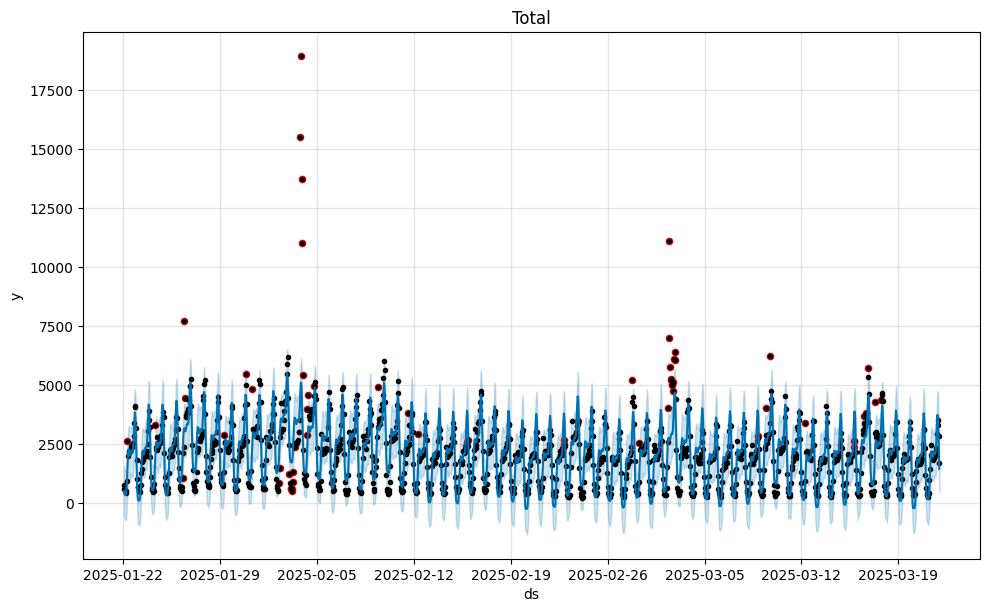

In [7]:
visitors_top_level = prophet_model(visitors_by_geography, 'Total')
visitors_top_level

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmg5u93lz/y617o1km.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmg5u93lz/hcm5rtac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21952', 'data', 'file=/tmp/tmpmg5u93lz/y617o1km.json', 'init=/tmp/tmpmg5u93lz/hcm5rtac.json', 'output', 'file=/tmp/tmpmg5u93lz/prophet_modelq7gx4pku/prophet_model-20250422224429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:44:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:44:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds  yhat_lower  yhat_upper        yhat    y  is_anomaly  \
0    2025-01-22 01:00:00  -41.046597   14.441678  -14.242673    5           0   
1    2025-01-22 02:00:00  -42.193237   12.243569  -14.737189    8           0   
2    2025-01-22 03:00:00  -40.535628   14.827902  -13.157859    5           0   
3    2025-01-22 04:00:00  -41.154956   11.006965  -14.606078    4           0   
4    2025-01-22 05:00:00  -44.064818   11.331440  -14.437433    3           0   
...                  ...         ...         ...         ...  ...         ...   
1409 2025-03-21 19:00:00  105.144509  161.481013  133.298372  123           0   
1410 2025-03-21 20:00:00  115.610419  167.986245  143.369183  121           0   
1411 2025-03-21 21:00:00  103.601850  157.416504  132.190170  127           0   
1412 2025-03-21 22:00:00   73.419390  129.189659   99.645561   84           0   
1413 2025-03-21 23:00:00   29.612890   85.603275   59.212357   49           0   

           diff  percent_diff  
0     19.242673      3.848535  
1     22.737189      2.842149  
2     18.157859      3.631572  
3     18.606078      4.651519  
4     17.437433      5.812478  
...         ...           ...  
1409  10.298372      0.083727  
1410  22.369183      0.184869  
1411   5.190170      0.040867  
1412  15.645561      0.186257  
1413  10.212357      0.208415  

[1414 rows x 8 columns]

<Figure size 3000x2000 with 0 Axes>

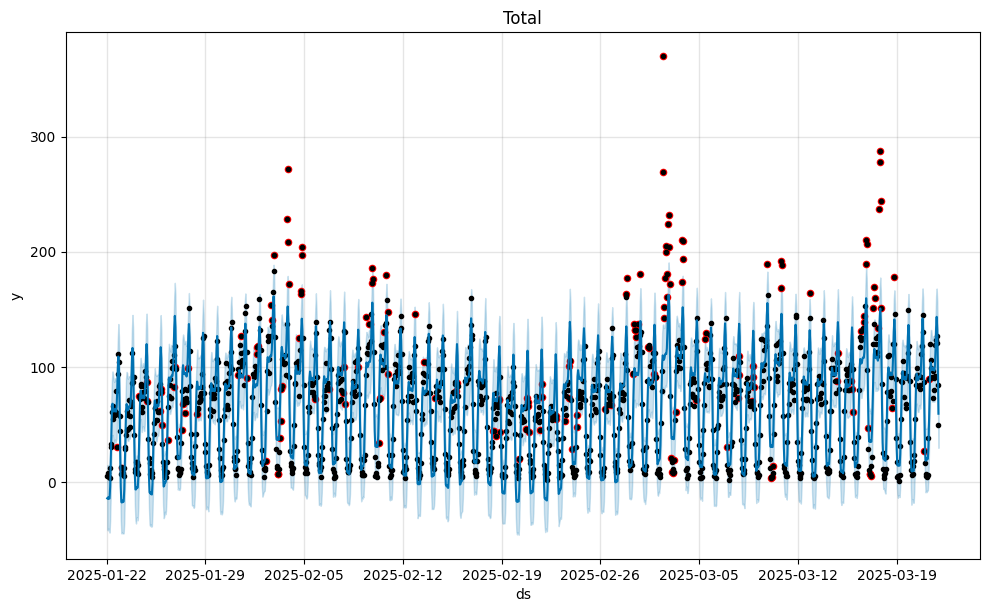

In [8]:
orders_top_level = prophet_model(orders_by_geography, 'Total')
orders_top_level

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmg5u93lz/ouci46s8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmg5u93lz/ocbtomzk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32741', 'data', 'file=/tmp/tmpmg5u93lz/ouci46s8.json', 'init=/tmp/tmpmg5u93lz/ocbtomzk.json', 'output', 'file=/tmp/tmpmg5u93lz/prophet_modelhjfg043m/prophet_model-20250422224430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:44:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:44:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds  yhat_lower  yhat_upper        yhat    y  is_anomaly  \
0    2025-01-22 01:00:00  -41.046597   14.441678  -14.242673    5           0   
1    2025-01-22 02:00:00  -42.193237   12.243569  -14.737189    8           0   
2    2025-01-22 03:00:00  -40.535628   14.827902  -13.157859    5           0   
3    2025-01-22 04:00:00  -41.154956   11.006965  -14.606078    4           0   
4    2025-01-22 05:00:00  -44.064818   11.331440  -14.437433    3           0   
...                  ...         ...         ...         ...  ...         ...   
1409 2025-03-21 19:00:00  105.144509  161.481013  133.298372  123           0   
1410 2025-03-21 20:00:00  115.610419  167.986245  143.369183  121           0   
1411 2025-03-21 21:00:00  103.601850  157.416504  132.190170  127           0   
1412 2025-03-21 22:00:00   73.419390  129.189659   99.645561   84           0   
1413 2025-03-21 23:00:00   29.612890   85.603275   59.212357   49           0   

           diff  percent_diff  
0     19.242673      3.848535  
1     22.737189      2.842149  
2     18.157859      3.631572  
3     18.606078      4.651519  
4     17.437433      5.812478  
...         ...           ...  
1409  10.298372      0.083727  
1410  22.369183      0.184869  
1411   5.190170      0.040867  
1412  15.645561      0.186257  
1413  10.212357      0.208415  

[1414 rows x 8 columns]

<Figure size 3000x2000 with 0 Axes>

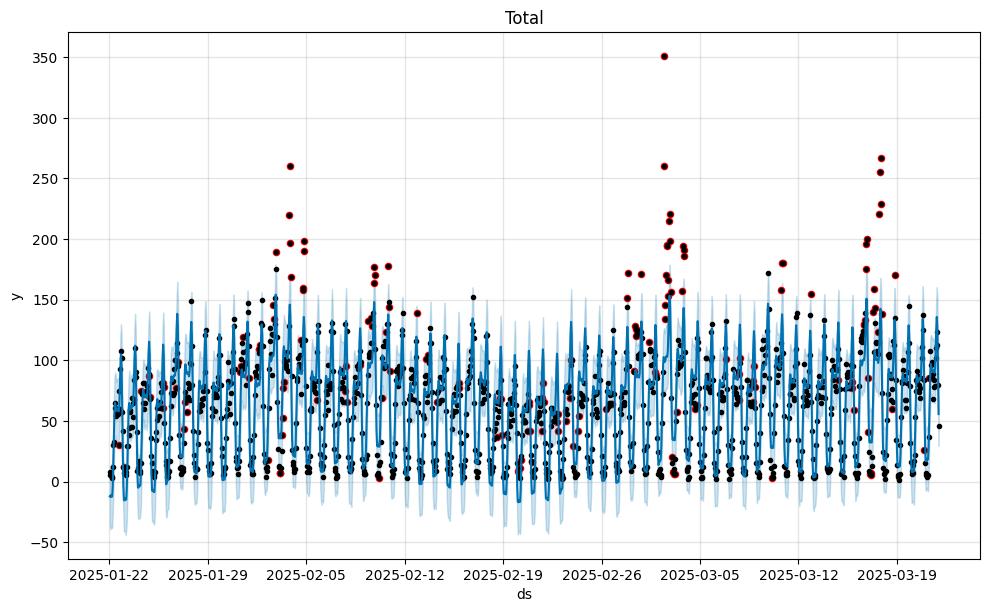

In [9]:
buyers_top_level = prophet_model(buyers_by_geography, 'Total')
orders_top_level

# Anomaly Contributions

In [11]:
def anomaly_contribution(site_visits_top_level,site_visits_bottom_level, dimension_list):
  site_visits_top_level_new = site_visits_top_level.copy()
  site_visits_top_level_new["pred added"] = 0
  site_visits_top_level_new["diff added"] = 0
  site_visits_top_level_new["diff sign added"] = 0

  for dimension in dimension_list:
    data_curr = prophet_model(site_visits_bottom_level, dimension)
    site_visits_top_level_new["pred "+dimension] = data_curr['yhat']
    site_visits_top_level_new["diff "+dimension] = data_curr['diff']
    site_visits_top_level_new['percent_diff ' + dimension] = data_curr['percent_diff']


    #Aggregated anomaly weights by dimension for verification with total anomaly weight found at top level
    site_visits_top_level_new["pred added"] += site_visits_top_level_new["pred "+dimension]
    site_visits_top_level_new["diff added"] += site_visits_top_level_new["diff "+dimension]


  for dimension in dimension_list:
    site_visits_top_level_new["perc diff "+dimension] = site_visits_top_level_new["diff "+dimension]/site_visits_top_level_new["diff added"]
    print(dimension + " added!")
  return site_visits_top_level_new

In [12]:
def anomaly_percents(site_visits_top_levell,site_visits_bottom_level, geo_list):
  site_visits_top_level_new = site_visits_top_levell.copy()
  for geo in geo_list:
    data_curr = prophet_model(site_visits_bottom_level, geo)
    # site_visits_top_level_new["diff "+geo] = data_curr['diff']
    site_visits_top_level_new["percent_diff "+geo] = data_curr['percent_diff']
  return site_visits_top_level_new

In [13]:
geo_list = ["Global", "US"]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmg5u93lz/mecm1mmz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmg5u93lz/s_tewmty.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19873', 'data', 'file=/tmp/tmpmg5u93lz/mecm1mmz.json', 'init=/tmp/tmpmg5u93lz/s_tewmty.json', 'output', 'file=/tmp/tmpmg5u93lz/prophet_modelaepjirzx/prophet_model-20250422225254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:52:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:52:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

ds   yhat_lower   yhat_upper         yhat     y  \
6   2025-01-22 07:00:00   405.696708  2487.837397  1392.667702  2630   
54  2025-01-24 07:00:00   731.611904  2674.634778  1676.315840  3328   
102 2025-01-26 07:00:00  1111.506102  3145.028039  2163.254175  1077   
105 2025-01-26 10:00:00  2163.935525  4229.813701  3179.310566  7715   
106 2025-01-26 11:00:00  1969.694967  4088.446446  3065.285446  4461   

     is_anomaly         diff  percent_diff  percent_diff Global  \
6             1  1237.332298      0.470469             0.520780   
54            1  1651.684160      0.496299             0.532596   
102           1  1086.254175      1.008593             1.043217   
105           1  4535.689434      0.587905             0.608181   
106           1  1395.714554      0.312870             0.345626   

     percent_diff US  
6           0.018035  
54          0.350825  
102         0.833152  
105         2.093055  
106         1.955231

<Figure size 3000x2000 with 0 Axes>

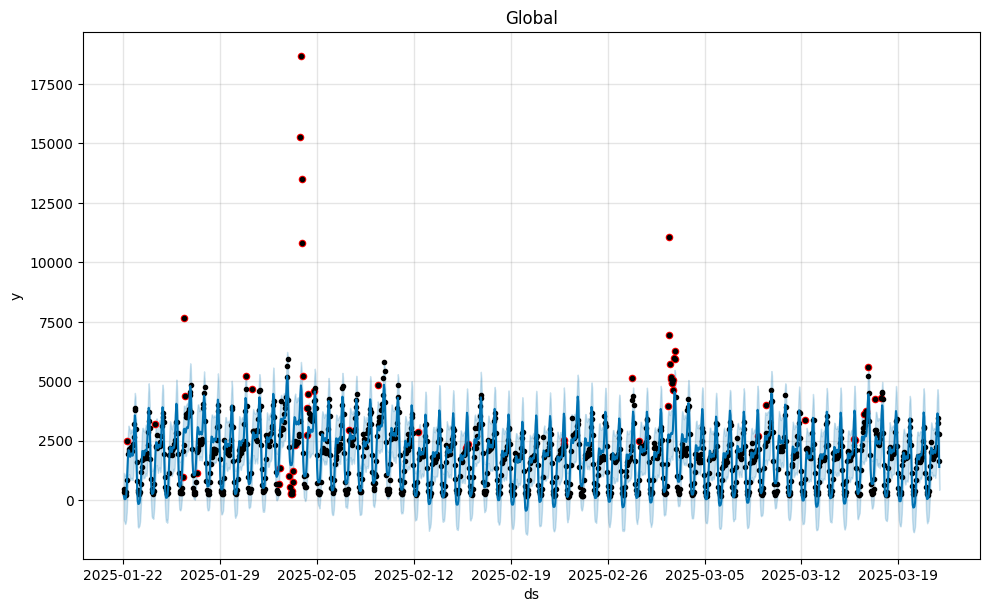

<Figure size 3000x2000 with 0 Axes>

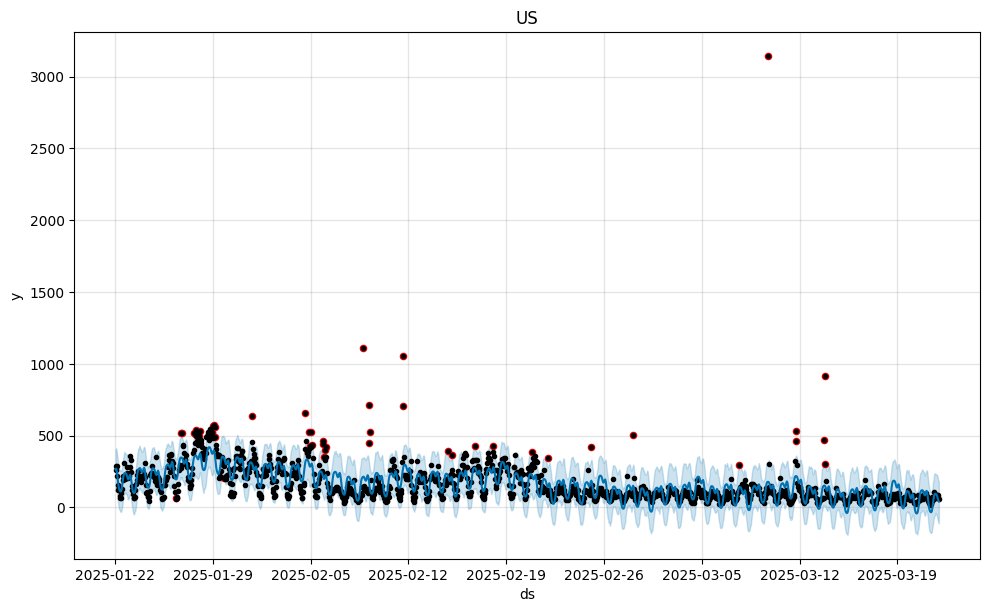

In [20]:
visitors_contributions = anomaly_percents(visitors_top_level,visitors_by_geography, geo_list)
visitors_geo_contributions = visitors_contributions[visitors_contributions["is_anomaly"] == 1]
visitors_geo_contributions.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmg5u93lz/see4bykk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmg5u93lz/odkd5xig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65541', 'data', 'file=/tmp/tmpmg5u93lz/see4bykk.json', 'init=/tmp/tmpmg5u93lz/odkd5xig.json', 'output', 'file=/tmp/tmpmg5u93lz/prophet_modelb47q4_dz/prophet_model-20250422225256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:52:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:52:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

ds  yhat_lower  yhat_upper        yhat   y  is_anomaly  \
16 2025-01-22 17:00:00   37.461877   91.077484   65.004238  30           1   
25 2025-01-23 02:00:00  -43.876230    8.541821  -17.925761  12           1   
54 2025-01-24 07:00:00    2.267717   55.007856   28.022147  75           1   
67 2025-01-24 20:00:00   93.765414  146.213380  119.714543  87           1   
68 2025-01-24 21:00:00   82.239325  133.527838  108.614245  70           1   

         diff  percent_diff  percent_diff Global  percent_diff US  
16  35.004238      1.166808             1.142094         1.562721  
25  29.925761      2.493813             6.823422         0.318322  
54  46.977853      0.626371             0.642287         0.224167  
67  32.714543      0.376029             0.415398         0.150764  
68  38.614245      0.551632             0.594073         0.004746

<Figure size 3000x2000 with 0 Axes>

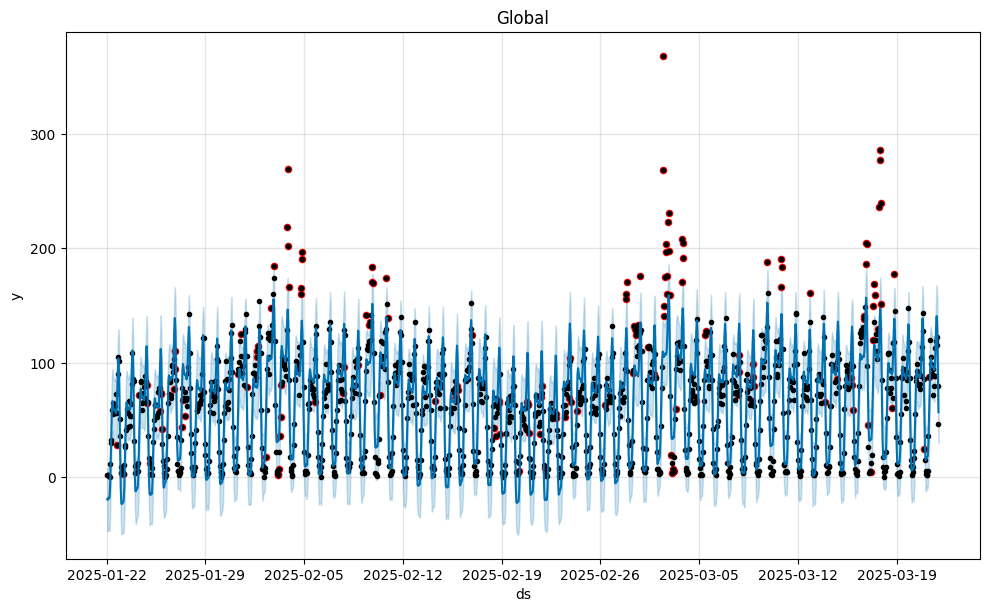

<Figure size 3000x2000 with 0 Axes>

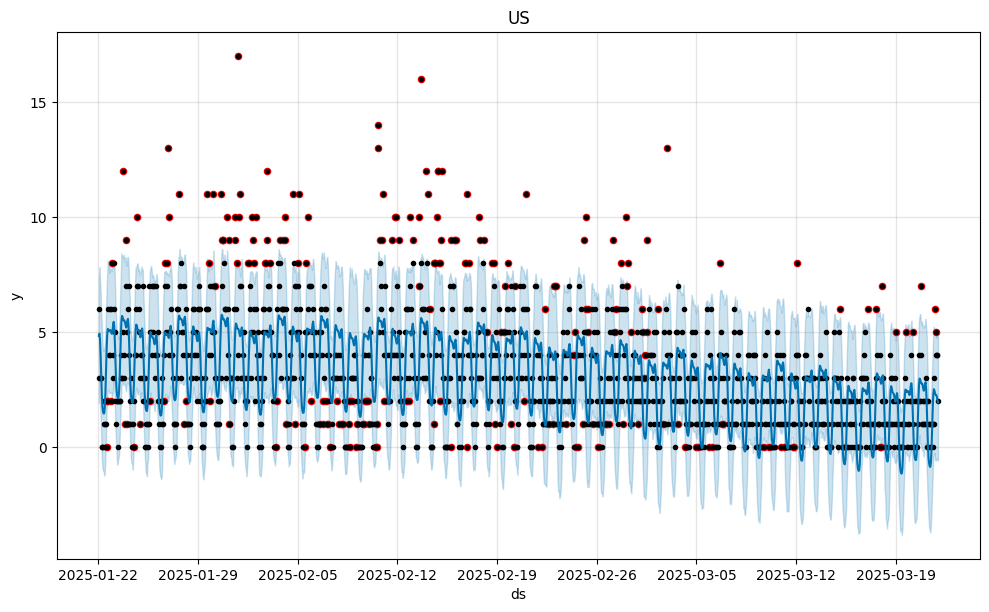

In [21]:
orders_contributions = anomaly_percents(orders_top_level,orders_by_geography, geo_list)
orders_geo_contributions = orders_contributions[orders_contributions["is_anomaly"] == 1]
orders_geo_contributions.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmg5u93lz/fyx55tpi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmg5u93lz/bx9jrp66.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14559', 'data', 'file=/tmp/tmpmg5u93lz/fyx55tpi.json', 'init=/tmp/tmpmg5u93lz/bx9jrp66.json', 'output', 'file=/tmp/tmpmg5u93lz/prophet_modelx1tjwk9j/prophet_model-20250422225302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:53:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:53:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

ds  yhat_lower  yhat_upper        yhat   y  is_anomaly  \
16 2025-01-22 17:00:00   36.909550   87.339639   61.694524  30           1   
25 2025-01-23 02:00:00  -41.408503    9.921166  -15.588409  12           1   
54 2025-01-24 07:00:00    3.471046   54.183054   28.029504  75           1   
67 2025-01-24 20:00:00   90.563869  140.289456  115.313417  87           1   
68 2025-01-24 21:00:00   81.014871  130.587959  104.948104  70           1   

         diff  percent_diff  percent_diff Global  percent_diff US  
16  31.694524      1.056484             1.042380         1.378717  
25  27.588409      2.299034             6.126205         0.354930  
54  46.970496      0.626273             0.637471         0.282017  
67  28.313417      0.325442             0.365821         0.188529  
68  34.948104      0.499259             0.542868         0.030854

<Figure size 3000x2000 with 0 Axes>

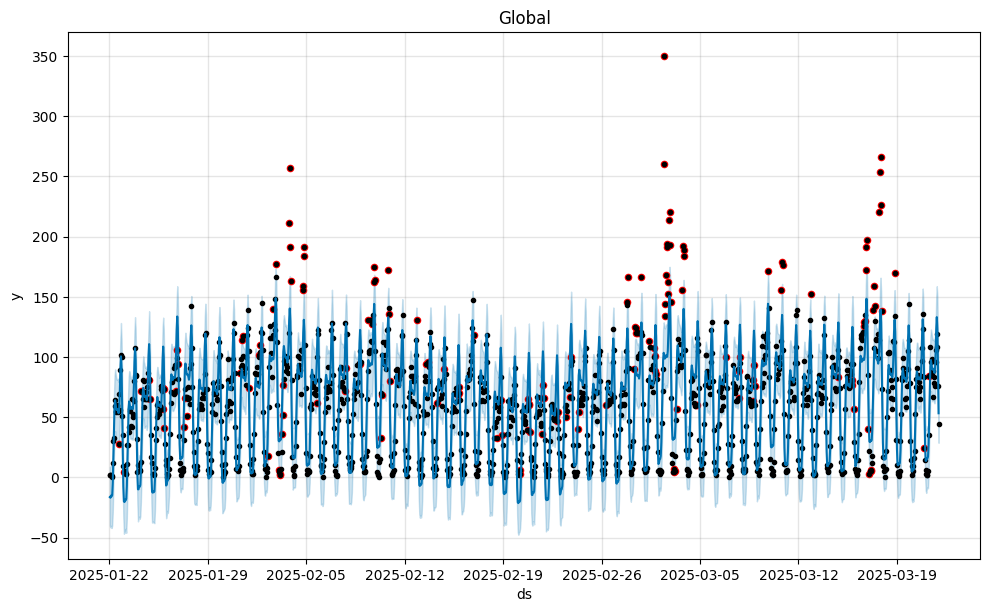

<Figure size 3000x2000 with 0 Axes>

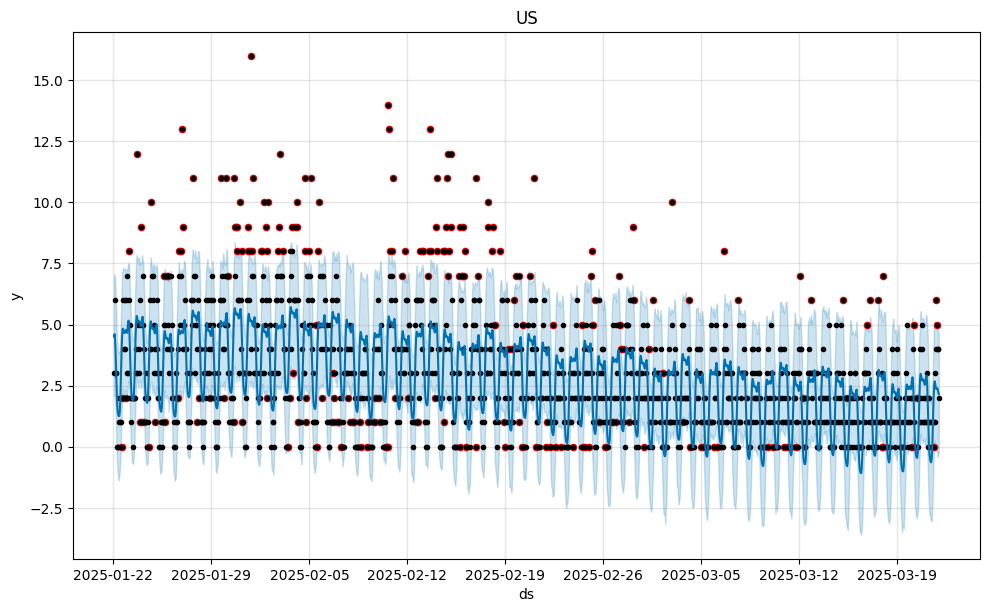

In [22]:
buyers_contributions = anomaly_percents(buyers_top_level,buyers_by_geography, geo_list)
buyers_geo_contributions = buyers_contributions[buyers_contributions["is_anomaly"] == 1]
buyers_geo_contributions.head()

In [26]:
devices = ["Android",	"Linux", "macOS",	"Other",	"Windows",	"iOS"]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmg5u93lz/nx1nwtf1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmg5u93lz/v5vlurgv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99375', 'data', 'file=/tmp/tmpmg5u93lz/nx1nwtf1.json', 'init=/tmp/tmpmg5u93lz/v5vlurgv.json', 'output', 'file=/tmp/tmpmg5u93lz/prophet_modelyflgc58x/prophet_model-20250422225450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:54:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:54:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

Android added!
Linux added!
macOS added!
Other added!
Windows added!
iOS added!


ds   yhat_lower   yhat_upper         yhat     y  \
6   2025-01-22 07:00:00   405.696708  2487.837397  1392.667702  2630   
54  2025-01-24 07:00:00   731.611904  2674.634778  1676.315840  3328   
102 2025-01-26 07:00:00  1111.506102  3145.028039  2163.254175  1077   
105 2025-01-26 10:00:00  2163.935525  4229.813701  3179.310566  7715   
106 2025-01-26 11:00:00  1969.694967  4088.446446  3065.285446  4461   

     is_anomaly         diff  percent_diff   pred added   diff added  ...  \
6             1  1237.332298      0.470469  1309.601574  1331.806103  ...   
54            1  1651.684160      0.496299  1641.669833  1691.841557  ...   
102           1  1086.254175      1.008593  2174.297116  1097.297116  ...   
105           1  4535.689434      0.587905  3193.109303  4677.076471  ...   
106           1  1395.714554      0.312870  3079.951877  1565.925096  ...   

     percent_diff Windows     pred iOS     diff iOS  percent_diff iOS  \
6                0.735269   912.509334   606.490666          0.399270   
54               0.706800  1124.242398  1015.757602          0.474653   
102              3.994810  1568.536775   739.536775          0.892083   
105              0.572092  2298.102822  3674.897178          0.615251   
106              0.122246  2212.525652  1258.474348          0.362568   

     perc diff Android  perc diff Linux  perc diff macOS  perc diff Other  \
6             0.085858         0.247924         0.004283         0.001170   
54            0.138711         0.109639         0.008847         0.001629   
102           0.169574         0.081417         0.022576         0.019706   
105           0.137213         0.014254         0.019373         0.002336   
106           0.104946         0.043404         0.032361         0.005869   

     perc diff Windows  perc diff iOS  
6             0.205375       0.455390  
54            0.140788       0.600386  
102           0.032765       0.673962  
105           0.041099       0.785725  
106           0.009758       0.803662  

[5 rows x 35 columns]

<Figure size 3000x2000 with 0 Axes>

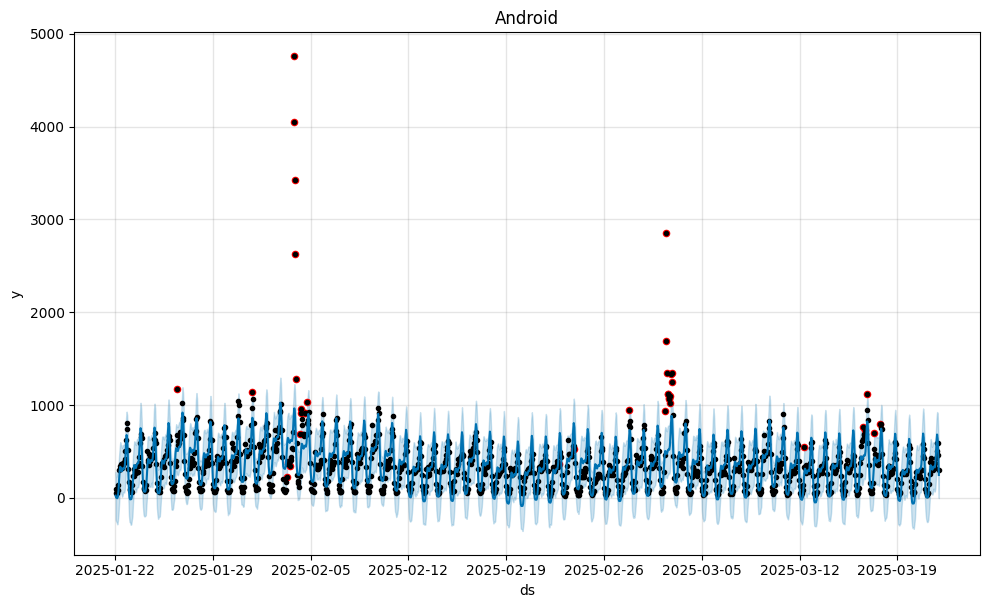

<Figure size 3000x2000 with 0 Axes>

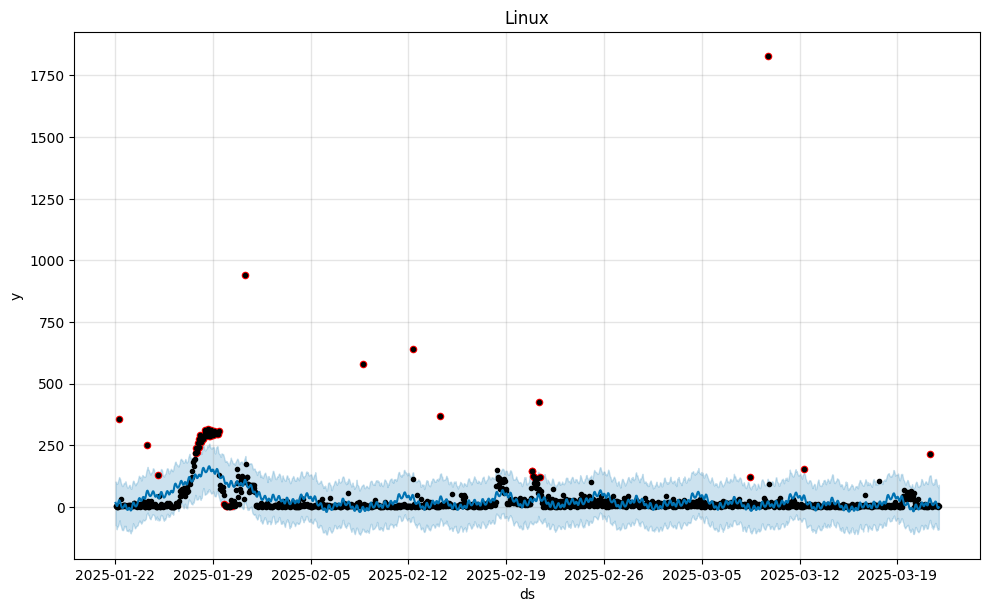

<Figure size 3000x2000 with 0 Axes>

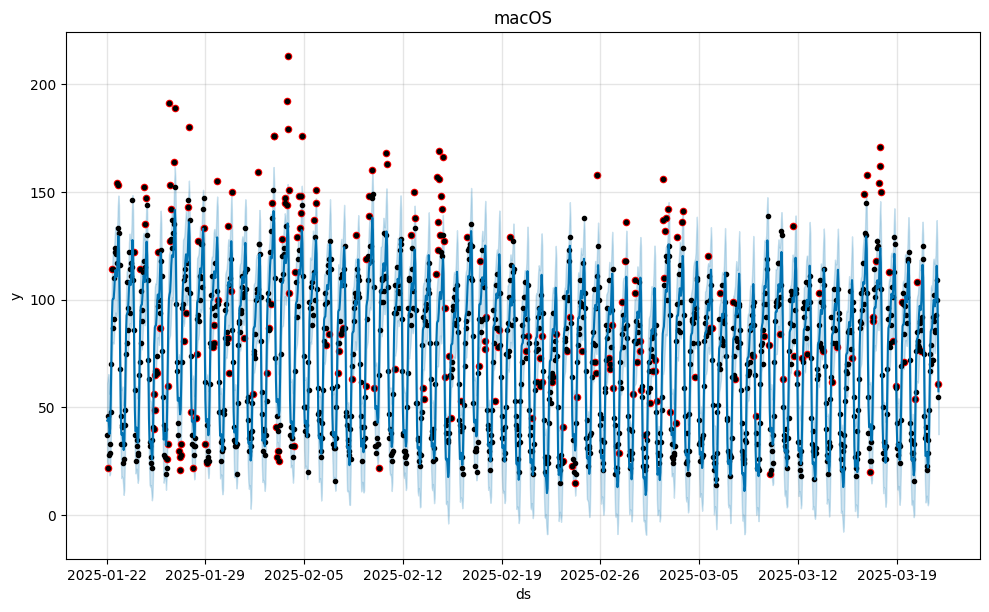

<Figure size 3000x2000 with 0 Axes>

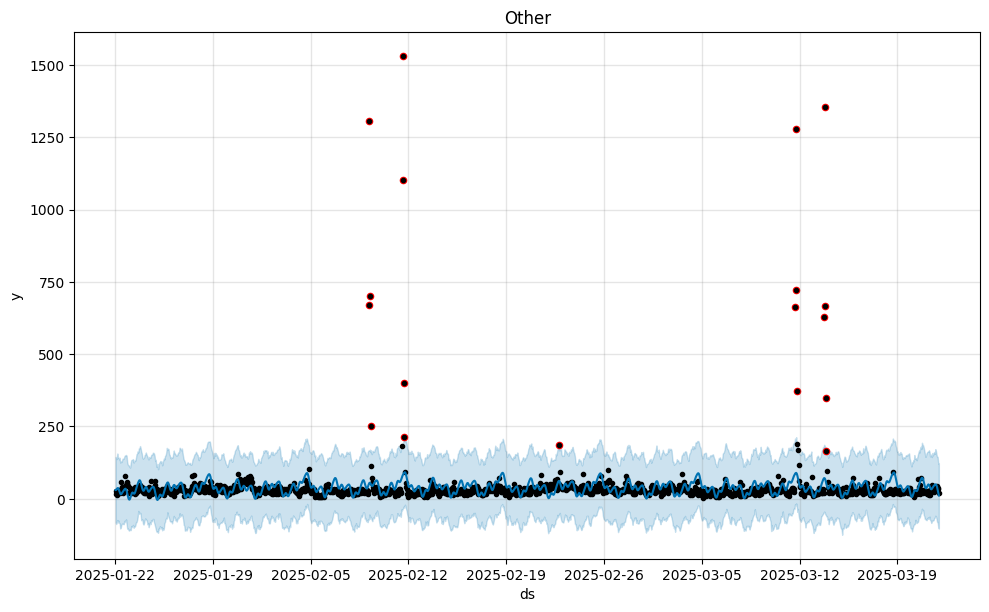

<Figure size 3000x2000 with 0 Axes>

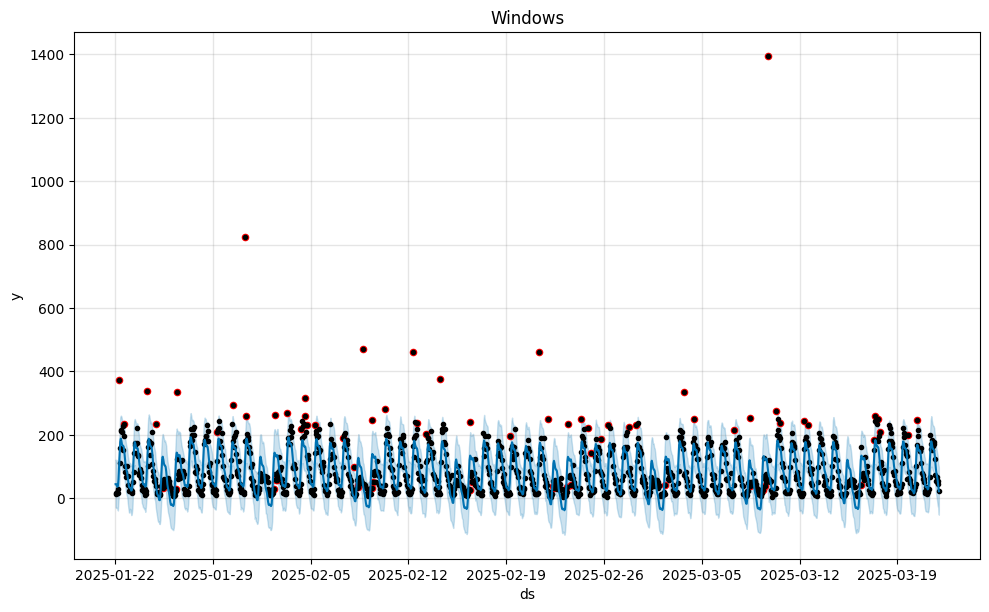

<Figure size 3000x2000 with 0 Axes>

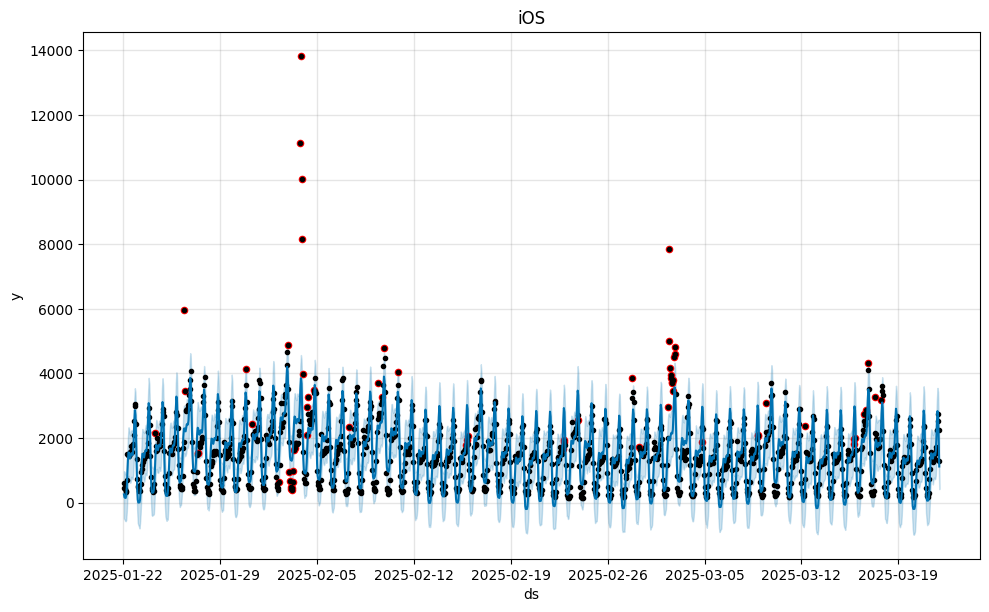

In [27]:
visitors_contribution_dev = anomaly_contribution(visitors_top_level,visitors_by_device, devices)
visitors_contributions_device = visitors_contribution_dev[visitors_contribution_dev["is_anomaly"] == 1]
visitors_contributions_device.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmg5u93lz/65_0iw84.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmg5u93lz/wbqwzbmb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15540', 'data', 'file=/tmp/tmpmg5u93lz/65_0iw84.json', 'init=/tmp/tmpmg5u93lz/wbqwzbmb.json', 'output', 'file=/tmp/tmpmg5u93lz/prophet_modelz9z9cq44/prophet_model-20250422225625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:56:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:56:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

Android added!
Linux added!
macOS added!
Other added!
Windows added!
iOS added!


ds  yhat_lower  yhat_upper        yhat   y  is_anomaly  \
16 2025-01-22 17:00:00   37.461877   91.077484   65.004238  30           1   
25 2025-01-23 02:00:00  -43.876230    8.541821  -17.925761  12           1   
54 2025-01-24 07:00:00    2.267717   55.007856   28.022147  75           1   
67 2025-01-24 20:00:00   93.765414  146.213380  119.714543  87           1   
68 2025-01-24 21:00:00   82.239325  133.527838  108.614245  70           1   

         diff  percent_diff  pred added  diff added  ...  \
16  35.004238      1.166808   65.296863   35.296863  ...   
25  29.925761      2.493813  -17.670726   31.224715  ...   
54  46.977853      0.626371   28.248509   51.799733  ...   
67  32.714543      0.376029  119.895809   36.080430  ...   
68  38.614245      0.551632  108.791587   40.248779  ...   

    percent_diff Windows   pred iOS   diff iOS  percent_diff iOS  \
16              4.163500  43.302346  20.302346          0.882711   
25                   NaN -14.591135  24.591135          2.459113   
54                   NaN  19.955936  43.044064          0.683239   
67              0.182307  88.952742  22.952742          0.347769   
68              0.483642  80.746819  31.746819          0.647894   

    perc diff Android  perc diff Linux  perc diff macOS  perc diff Other  \
16           0.155914         0.001930         0.144571         0.004440   
25           0.187563         0.000689         0.006882         0.000121   
54           0.113453         0.001304         0.006721         0.000126   
67           0.297127         0.023921         0.014262         0.008324   
68           0.162979         0.003350         0.002771         0.018102   

    perc diff Windows  perc diff iOS  
16           0.117957       0.575188  
25           0.017192       0.787554  
54           0.047425       0.830971  
67           0.020211       0.636155  
68           0.024033       0.788765  

[5 rows x 35 columns]

<Figure size 3000x2000 with 0 Axes>

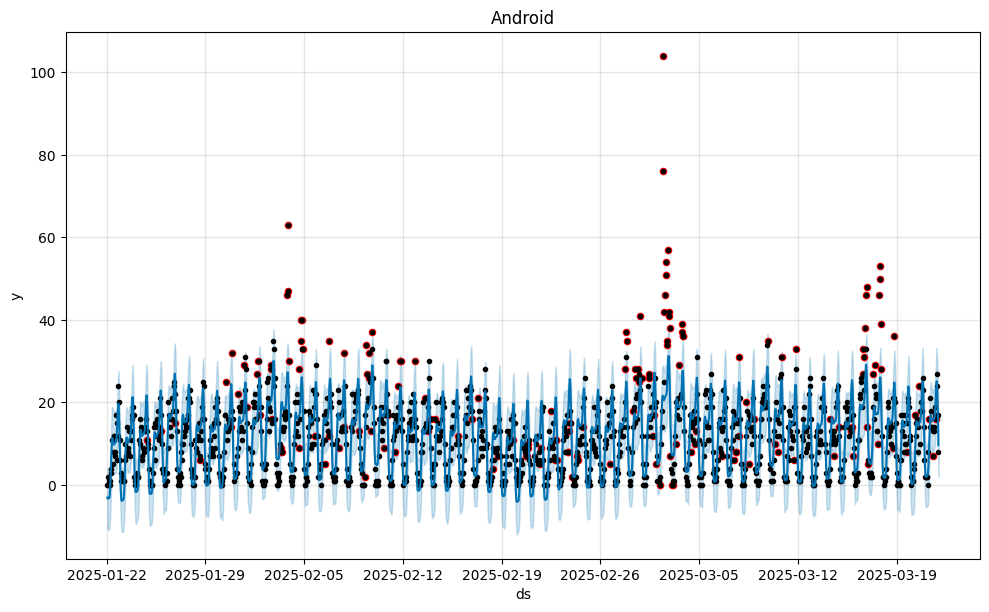

<Figure size 3000x2000 with 0 Axes>

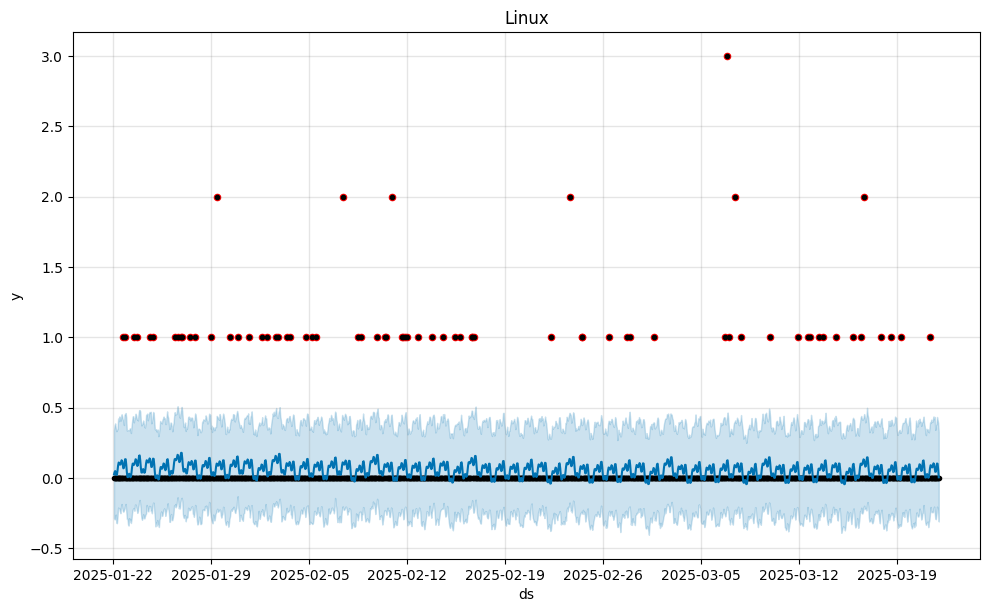

<Figure size 3000x2000 with 0 Axes>

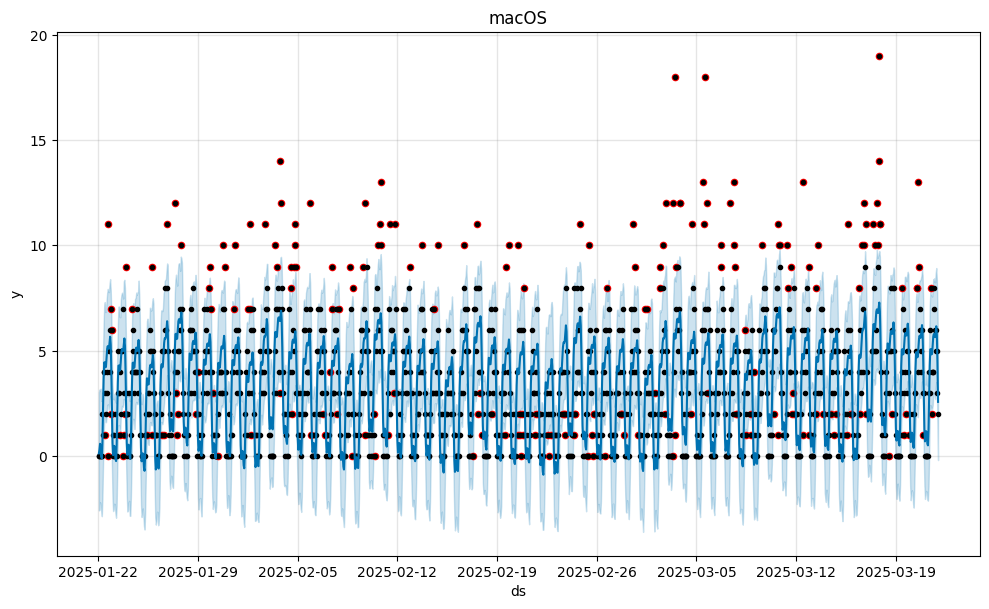

<Figure size 3000x2000 with 0 Axes>

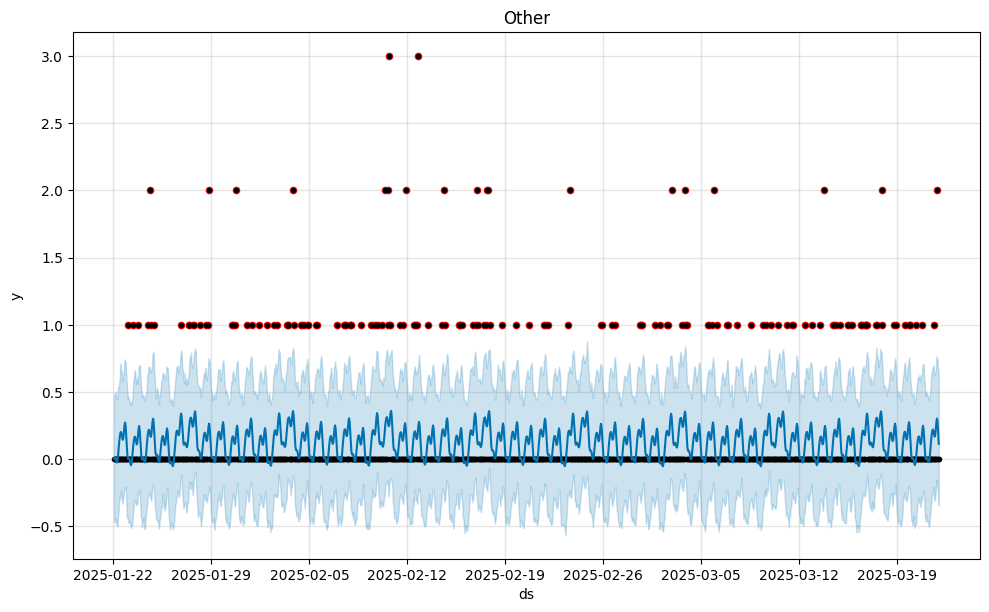

<Figure size 3000x2000 with 0 Axes>

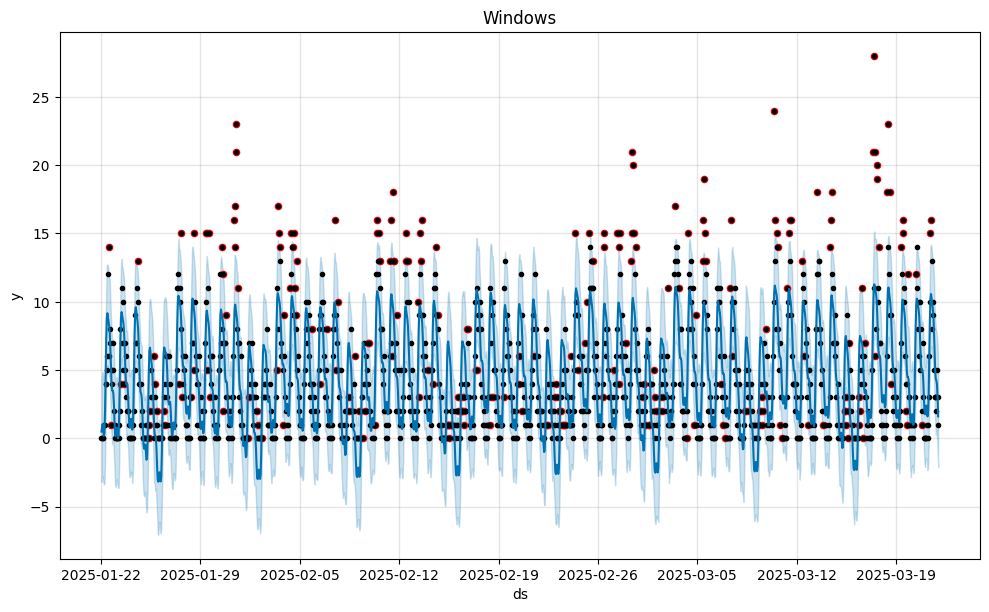

<Figure size 3000x2000 with 0 Axes>

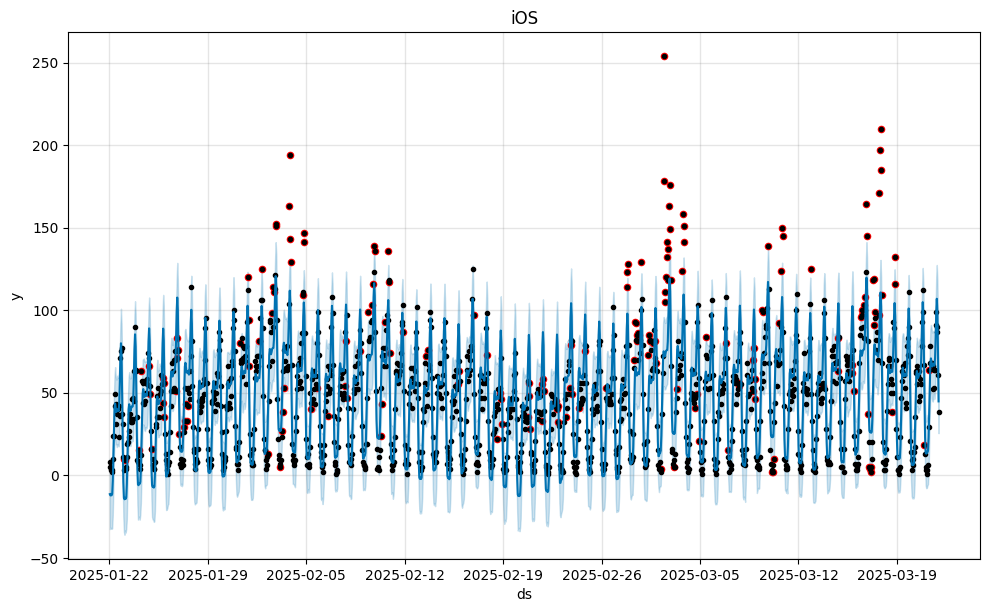

In [28]:
orders_contribution_dev = anomaly_contribution(orders_top_level, orders_by_device, devices)
orders_contributions_device = orders_contribution_dev[orders_contribution_dev["is_anomaly"] == 1]
orders_contributions_device.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmg5u93lz/zb7x_czh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmg5u93lz/xvgvpewl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79676', 'data', 'file=/tmp/tmpmg5u93lz/zb7x_czh.json', 'init=/tmp/tmpmg5u93lz/xvgvpewl.json', 'output', 'file=/tmp/tmpmg5u93lz/prophet_modelayjoeh_j/prophet_model-20250422225827.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:58:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:58:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

Android added!
Linux added!
macOS added!
Other added!
Windows added!
iOS added!


ds  yhat_lower  yhat_upper        yhat   y  is_anomaly  \
16 2025-01-22 17:00:00   36.909550   87.339639   61.694524  30           1   
25 2025-01-23 02:00:00  -41.408503    9.921166  -15.588409  12           1   
54 2025-01-24 07:00:00    3.471046   54.183054   28.029504  75           1   
67 2025-01-24 20:00:00   90.563869  140.289456  115.313417  87           1   
68 2025-01-24 21:00:00   81.014871  130.587959  104.948104  70           1   

         diff  percent_diff  pred added  diff added  ...  \
16  31.694524      1.056484   62.685250   32.685250  ...   
25  27.588409      2.299034  -14.669837   28.662543  ...   
54  46.970496      0.626273   28.867271   51.131517  ...   
67  28.313417      0.325442  116.063867   32.359514  ...   
68  34.948104      0.499259  105.691990   37.174835  ...   

    percent_diff Windows   pred iOS   diff iOS  percent_diff iOS  \
16              3.847498  42.397717  19.397717          0.843379   
25                   NaN -12.375033  22.375033          2.237503   
54                   NaN  20.468877  42.531123          0.675097   
67              0.193502  86.276744  20.276744          0.307223   
68              0.477913  78.509104  29.509104          0.602227   

    perc diff Android  perc diff Linux  perc diff macOS  perc diff Other  \
16           0.148487         0.002296         0.133328         0.004706   
25           0.184184         0.000817         0.009792         0.000418   
54           0.113797         0.001016         0.005456         0.000066   
67           0.298798         0.027003         0.014851         0.008820   
68           0.154915         0.003406         0.002230         0.019944   

    perc diff Windows  perc diff iOS  
16           0.117714       0.593470  
25           0.024152       0.780637  
54           0.047866       0.831799  
67           0.023919       0.626608  
68           0.025712       0.793792  

[5 rows x 35 columns]

<Figure size 3000x2000 with 0 Axes>

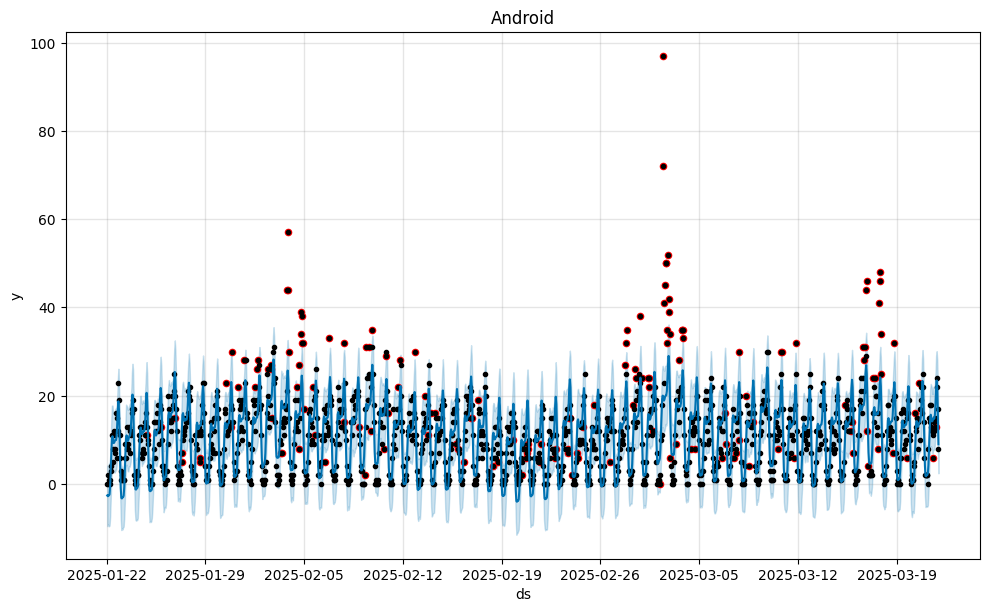

<Figure size 3000x2000 with 0 Axes>

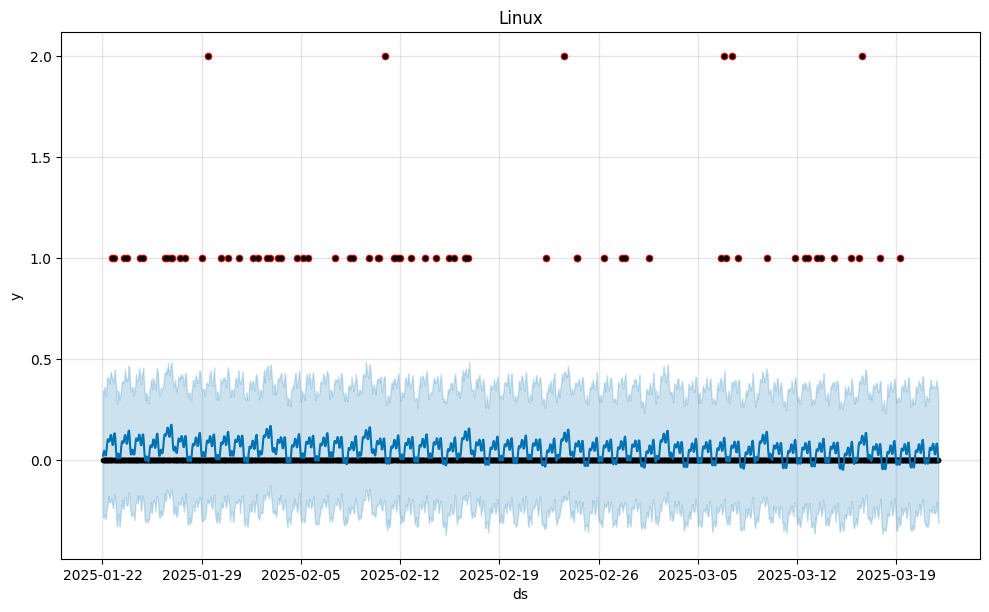

<Figure size 3000x2000 with 0 Axes>

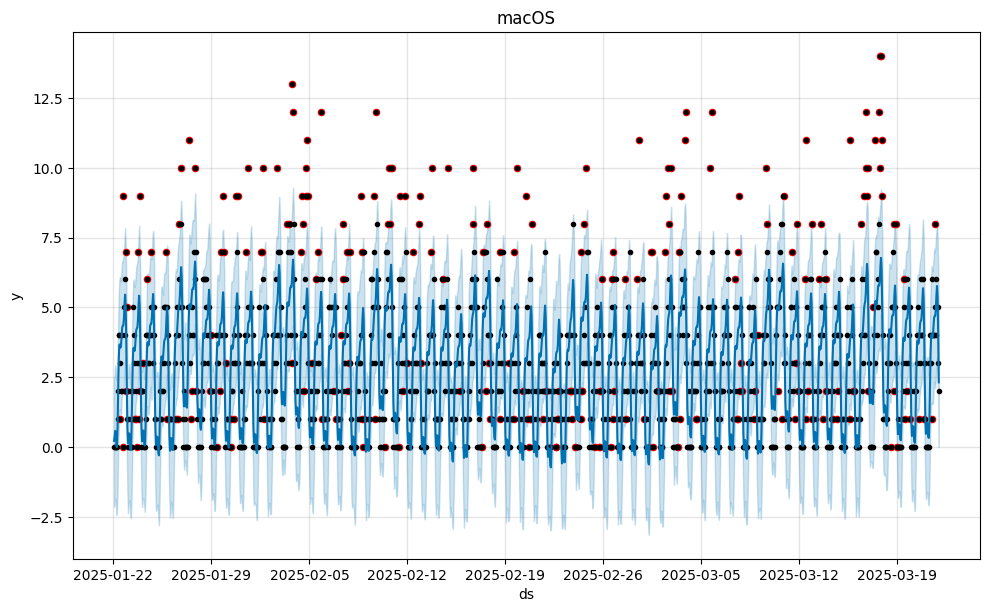

<Figure size 3000x2000 with 0 Axes>

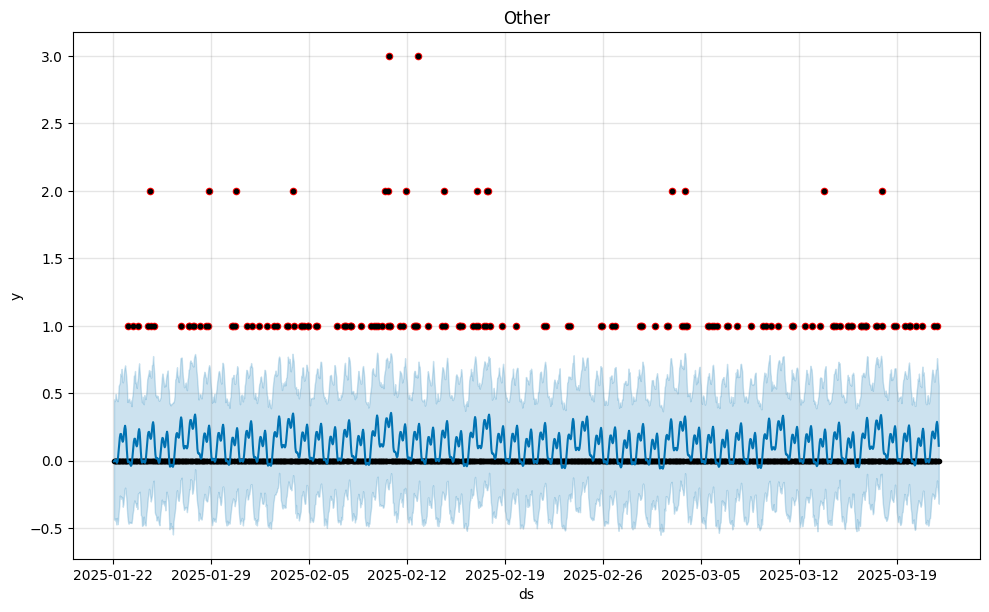

<Figure size 3000x2000 with 0 Axes>

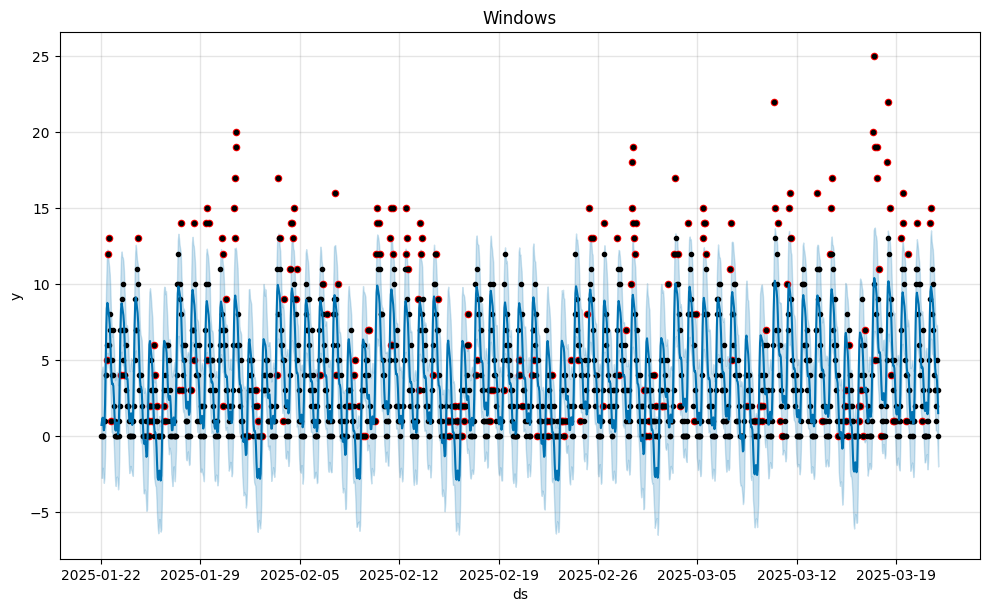

<Figure size 3000x2000 with 0 Axes>

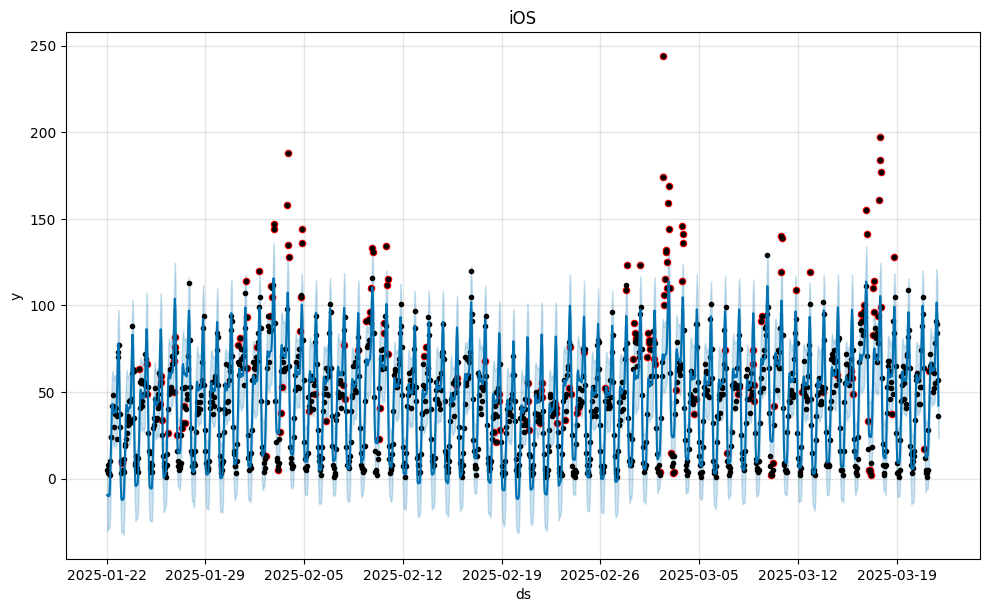

In [29]:
buyers_contribution_dev = anomaly_contribution(buyers_top_level, buyers_by_device, devices)
buyers_contributions_device = buyers_contribution_dev[buyers_contribution_dev["is_anomaly"] == 1]
buyers_contributions_device.head()

In [31]:
visitors_anomaly_percentages_device = visitors_contributions_device.set_index('ds')[["percent_diff "+device for device in devices]]
visitor_anomaly_percentages_geo = visitors_geo_contributions.set_index('ds')[["percent_diff Global", "percent_diff US"]]
visitor_anomaly_percentages_geo

percent_diff Global  percent_diff US
ds                                                       
2025-01-22 07:00:00             0.520780         0.018035
2025-01-24 07:00:00             0.532596         0.350825
2025-01-26 07:00:00             1.043217         0.833152
2025-01-26 10:00:00             0.608181         2.093055
2025-01-26 11:00:00             0.345626         1.955231
...                                  ...              ...
2025-03-16 12:00:00             0.311200         0.419172
2025-03-16 16:00:00             0.282248         0.608537
2025-03-16 19:00:00             0.282418         0.352620
2025-03-17 07:00:00             0.576341         1.263837
2025-03-17 18:00:00             0.314178         0.374285

[63 rows x 2 columns]

In [32]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def find_eps(df):
  nn = NearestNeighbors(n_neighbors=8).fit(df)
  distances, indices = nn.kneighbors(df)
  distances = np.sort(distances, axis=0)
  distances = distances[:,1]
  kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve="convex", direction="increasing")
  kneedle.plot_knee()
  return distances[kneedle.elbow]

def find_maximum_contributors(df, index, eps):
  reshaped_row = np.array(df.iloc[index].to_list()).reshape(-1, 1)
  db = DBSCAN(eps=eps*0.5, min_samples=1).fit(reshaped_row)
  labels = db.labels_
  clusters = {}
  for label in set(labels):
    clusters[label] = reshaped_row[labels == label]
  sorted_clusters = {k: clusters[k] for k in sorted(clusters, key=lambda k: max(clusters[k]), reverse=True)}
  max_contributors = sorted_clusters[list(sorted_clusters.keys())[0]]
  if len(sorted_clusters.keys()) == 1:
    return
  contributing_columns = []
  for val in max_contributors:
    col_index = list(reshaped_row).index(val)
    contributing_columns.append(df.columns[col_index])
  return contributing_columns

def create_contributor_col(df):
  df = df.fillna(0)
  eps = find_eps(df)
  contribution_list = []
  for i in range(df.shape[0]):
    contribution_list.append(find_maximum_contributors(df, i, eps))
  df['Contributors'] = contribution_list
  return df

ds  percent_diff Android  percent_diff Linux  \
0 2025-01-22 07:00:00              0.377379            0.924894   
1 2025-01-24 07:00:00              0.466556            0.741965   
2 2025-01-26 07:00:00              0.995044           29.779620   
3 2025-01-26 10:00:00              0.547105            3.921508   
4 2025-01-26 11:00:00              0.244549            6.178810   

   percent_diff macOS  percent_diff Other  percent_diff Windows  \
0            0.118830            0.050262              0.735269   
1            0.230272            0.083506              0.706800   
2            0.952775            0.940126              3.994810   
3            0.474394            0.437090              0.572092   
4            0.331211            0.316924              0.122246   

   percent_diff iOS          Contributors  
0          0.399270                  None  
1          0.474653                  None  
2          0.892083  [percent_diff Linux]  
3          0.615251  [percent_diff Linux]  
4          0.362568  [percent_diff Linux]

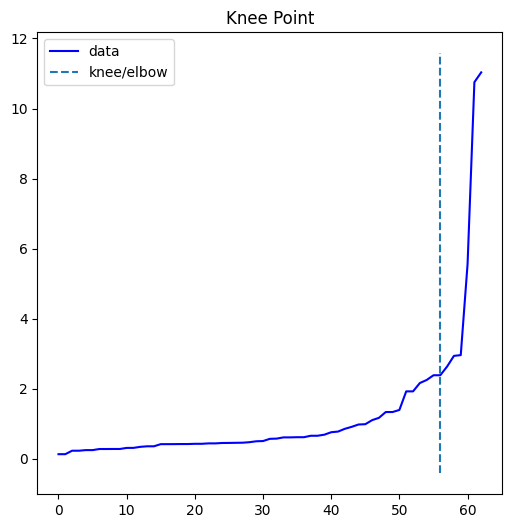

In [33]:
visitor_device_contributing_columns = create_contributor_col(visitors_anomaly_percentages_device)
visitor_device_contributing_columns.reset_index(inplace=True)
visitor_device_contributing_columns.head()